<img src="resources/header.png"/>

# Gaussian Process extrapolation as probabilistic program synthesis
Authored by: Ulli Schaechtle, Ph.D. of the MIT Probabilistic Computing Project (Probcomp). Prepared for: Probcomp's workshop at the O'Reilly Media AI Conference, June 27, 2017, New York City.

## Outline

1. Introduction
2. Training data
3. GP probabilistic programming prior
4. Observe data
5. Inference
6. Extrapolation accuracy
7. Compare posterior predictive with Bayesian linear regresssion
8. References

## 1. Introduction

Recent work by [1] and [2] showed it is possible
to use Gaussian Processes (GPs) to discover covariance structure in univariate
time series. 
We have implemented the approach from
[1] by using probabilistic program synthesis for Bayesian
learning over the symbolic structure of GP covariance kernels.
The technique is implemented in under 150 lines of Venture code, shown
[below](hyperparameter-inference-with-gp.ipynb#Main-probabilstic-program-synthesis-prior).  Find our full paper on [time series structure discovery via probabilistic program synthesis on ArXiv](https://arxiv.org/abs/1611.07051).

#### Goal of this notebook:

Demonstrate extrapolation with probabilistic programming synthesis given real world data. The notebook shows how extrapolation results improve with increasing time spent on inference. 

#### Gaussian processes

We briefly review the Gaussian process, a nonparametric regression technique
that learns a function $f: \mathcal{X} \to \mathcal{Y}$. The GP prior can
express both simple parametric forms (such as polynomial functions), as well as
more complex relationships dictated by periodicity, smoothness, and so on.
Following the notations from [3], we formalize a Gaussian
process $f \sim \mathcal{GP}(m, k)$ with mean function $m: \mathcal{X} \to 
\mathcal{Y}$ and covariance function $k:
\mathcal{X} \times \mathcal{X} \to \mathbb{R}$ as a
collection of random variables $\{f(x): x \in \mathcal{X}\}$, any finite
subcollection $[f(x_1), \dots, f(x_n)]$ of which are jointly Gaussian with mean
vector $[m(x_1),\dots,m(x_n)]$ and covariance matrix
$[k(x_i,x_j)]_{1\le{i,j}\le{n}}$. While the mean function $m$ is typically set
to zero (as it can be expressed through covariance), the covariance kernel $k$
captures the essential features of the unknown function $f$, which are its
ability to (i) fit patterns in the data, and (ii) generalize to out-of-sample
predictions. Rich GP kernels can be created by composing simple (base) kernels
through sum, product, and changepoint operators [3, Section 4.2.4].

#### Starting VentureScript

Start the jupyter-probcomp extensions.

In [1]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [2]:
%ripl --seed 1 --plugins resources/python/gp_synth_plugins.py

Set seed of a new VentureScript RIPL to 1.00.
Loading plugin: resources/python/gp_synth_plugins.py


### 1. Training data

We load the training data into the notebook.

In [3]:
%%venturescript
define observed_input  = load_csv("resources/airline/x_training.csv");
define observed_output = load_csv("resources/airline/y_training.csv");

Next, we plot the raw data, to get a sense about the structural dynamics of the time
series.

To plot, we supply a venturescript dictionary that that basically mimics the keyword-
argument structure of python's matplotlib.

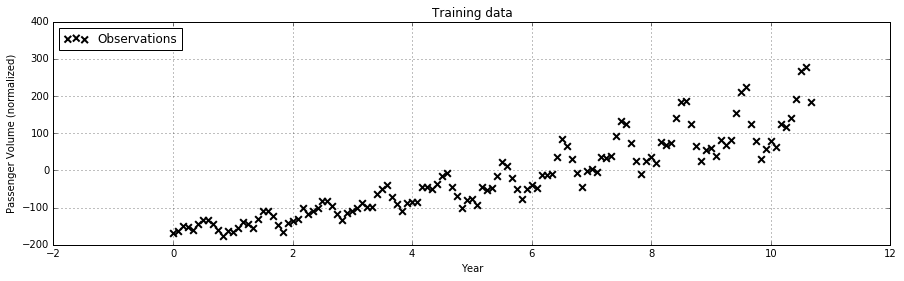

In [4]:
%%venturescript
define plotting_args_scatter = dict(
        ["xlabel", "Year"],
        ["ylabel", "Passenger Volume (normalized)"],
        ["label", "Observations"],
        ["title", "Training data"],
        ["markersize", 45],
        ["width", 15],
        ["height", 4],
        ["color", "black"]
);
scatter_plot(observed_input, observed_output, plotting_args_scatter);
legend("upper left");

**Figure 1: Airline passenger data.**
The training data shows trend of increasing passenger volume, as well a seasonal
(periodic) component that seems to determine the passenger volume at a given point in time.

## 3. Probabilistic programming synthesis prior & model 

Next, we run the probabilistic program synthesis model/prior.

#### GP-hyperparameter prior
We deploy a heuristic empirical prior on GP-kernel hyperparameters. We simply define
two different uniform distributions:

1. One between the minimum and the maximum of the observed input;
2. One between 0 and the maximum of the observed output;

Depending on the kind of kernel and type of hyperparameter, a hyperparameter is sampled from either one of these distributions.


In [5]:
%%venturescript
assume x_min = 0.; // minimum of observed input 
assume x_max = 10.6; // maximum of observed input 
assume y_max = 278.7; // maximum of observed output
assume get_hyper_prior ~ mem((node_index) -> {
    if (node_index[0] == "WN" or node_index[0] == "C") {
        // Sample hyper-priors ranging over the y axis.
        uniform_continuous(x_min, y_max) #hypers:node_index
    } else {
        // Sample hyper-priors ranging over the x axis.
        uniform_continuous(0, x_max) #hypers:node_index
    }
});

$
\newcommand{\dnin}{d^\textrm{in}}
\newcommand{\dnout}{d^\textrm{out}}
\newcommand{\Kprior}{\mathbf{K}^{\textrm{cov}}}
\newcommand{\abs}[1]{\left\lvert #1 \right\rvert}
$
#### Synthesis Model
We now describe the synthesis model ([abstract syntax tree (AST)](https://en.wikipedia.org/wiki/Abstract_syntax_tree) prior and AST interpreter), and the
class of synthesized model programs for learning GP covariance structures.
The AST prior $\mathcal{G}$ specifies a prior over binary trees.
Each leaf $n$ of $\mathcal{T}$ is a pair $(k_n, h_n)$
comprised of a base kernel and its hyperparmaters.

The base kernels are: white
noise (WN), constant (C), linear (LIN), squared exponential (SE), and periodic
(PER). Each base kernels has a set of hyperparameters; for instance, PER has a
lengthscale and period, and LIN has an x-intercept. Each internal node $n$
represents a composition operator $o_n$, which are: sum ($+$), product
($\times$), and changepoint (CP), whose hyperparameters are the
x-location of the change, and decay rate). The structure of $\mathcal{T}$ is
encoded by the index $n$ of each internal node (whose the left-child is $2n$ and
right child is $2n+1$) and the operators and base kernels at each node.


Let $N = \lvert\mathcal{T}\rvert$ denote the number of nodes. We write $\mathcal{T} =
\cup_{n=1}^{N}{\{x_n}\}$ as a collection of $N$ random variables, where $x_n =
(b_n, o_n, k_n, h_n)$ is a bundle of random variables for node $n$:
- $b_n$ is 1 if the tree branches at $n$ (and 0 if $n$ is a leaf);
- $o_n$ is the operator (or $\varnothing$ if $b_n=0$); 
- $k_n$ is the base kernel (or $\varnothing$ if $b_n=1$), and
- $h_n$ is the hyperparmater vector (or $\varnothing$ if $n$ has no hyperparameters e.g. if $b_n = 1$ and $o_n = +$).

Letting $\pi(n)$ denote the
list of all nodes in the path from $n$ up to the root, the tree prior is:

\begin{align*}
p_{\mathcal{G}}(\mathcal{T})
  &= \prod_{n=1}^{N}p_{\mathcal{G}}(x_n|x_{\pi(n)});
    p_{\mathcal{G}}(x_n|x_{\pi(n)})\\
  &= \prod_{n=1}^{N}
  \begin{cases}
  (1{-}p_\mathrm{branch})\,
    p_\mathrm{kernel}(k_n)\,
    p_\mathrm{hyper}(h_n\,{\mid}\,\mathrm{kernel} = k_n)
    & \textrm{if}\; b_n = 0,\\
  (p_\mathrm{branch})
    p_\mathrm{operator}(o_n)
    p_\mathrm{hyper}(h_n\,{\mid}\,\mathrm{operator} = o_n)
  & \textrm{if}\; b_n = 1,\\
  0
  & \textrm{if}\; x_n|x_{\pi(n)}\; \textrm{is inconsistent.}
  \notag
\end{cases}
\end{align*}

The distributions $p_\textrm{branch}$, $p_\textrm{kernel}$, and
$p_\mathrm{hyper}$ are all fixed constants in $\mathcal{G}$. As for the AST interpreter $\mathcal{I}$, it parses
$\mathcal{T}$ and deterministically outputs a GP model program with mean 0 and
covariance function encoded by $\mathcal{T}$, plus baseline noise. 
The synthesized GP model program $\mathcal{M}$ takes as input $k$ probe points $\dnin \in \mathbb{R}^k$, and produces
as output a (noisy) joint sample $\dnout \in \mathbb{R}^k$ of the GP at the probe
points:



\begin{align*}
\log P_\mathcal{M}(\dnout|\dnin)
&= \log \mathcal{N}(\dnout\mid 0, \Kprior +
  \sigma^2 \mathbf{I}) \quad\quad
  (
    \mathrm{with}\; \Kprior = \left[
      \mathrm{cov}\left(d^\text{in}_{a}, d^\text{in}_{b}\right)
    \right]_{1\le a,b \le k}
  )
\\
&= -\frac12 (\dnout)^\top (\Kprior + \sigma^2
  \mathbf{I})^{-1}\dnout
  - \frac12\log \abs{\Kprior + \sigma^2 \mathbf{I}}
  - \frac{k}{2}\log 2\pi.\\
\end{align*}


Find more details about the model [here](https://arxiv.org/abs/1611.07051).
In the following, we will introduce the Venture code for the probabilitic
programming synthesis model.


Get the index of the root of the tree.

In [6]:
%%venturescript
assume get_tree_root = () -> {1.0};

Roll a die to select a type of base kernel.

In [7]:
%%venturescript
assume get_base_kernel_index ~ mem((node_index) -> {
    uniform_discrete(0,5) #structure:node_index
});

Choose a primitive base kernel and sample its hyperparameters.

In [8]:
%%venturescript
assume choose_primitive =  (node_index) -> {
    rolled_dice = get_base_kernel_index(node_index);
    cond(
        (rolled_dice == 0)
            ([
                "WN",
                 get_hyper_prior(pair("WN", node_index))
            ]),
        (rolled_dice == 1)
            ([
                "C",
                 get_hyper_prior(pair("C", node_index))
            ]),
        (rolled_dice == 2)
            ([
                "LIN",
                 get_hyper_prior(pair("LIN", node_index))
            ]),
        (rolled_dice == 3)
            ([
                "SE",
                0.01 + get_hyper_prior(pair("SE", node_index))
            ]),
        (rolled_dice == 4)
            ([
                "PER",
                0.01 + get_hyper_prior(pair("PER_l", node_index)),
                0.01 + get_hyper_prior(pair("PER_t", node_index))
            ]),
    else("error"))
};

Choose an algebraic kernel operator; either:
- kernel sum;
- kernel product; or
- or change point combinator.

In [9]:
%%venturescript
assume choose_operator = mem((node_index) -> {
    operator_symbol ~ categorical(
        simplex(0.45, 0.45, 0.1),
        ["+", "*", "CP"]
    ) #structure:pair("operator", node_index);
    if (operator_symbol == "CP") {
        [
            operator_symbol,
            get_hyper_prior(pair("CP", node_index))
        ]
    } else {
        operator_symbol
    }
});

Generate a random program.

In [10]:
%%venturescript
assume generate_random_program = mem((node_index) -> {
    if (flip(0.3) #structure:pair("branch", node_index)) {
        operator ~ choose_operator(node_index);
        [
            operator,
            generate_random_program(2 * node_index),
            generate_random_program((2 * node_index + 1))
        ]
    } else {
        choose_primitive(node_index)
    }
});

Sample program source.

In [11]:
%%venturescript
assume source ~ generate_random_program(get_tree_root()) #GP;

Interpret the source.

In [12]:
%%venturescript
assume produce_covariance = (source) -> {
    cond(
        (source[0] == "WN") (
                gp_cov_scale(
                    source[1],
                    gp_cov_bump(0.000000001, 0.00000000001)
                )
            ),
        (source[0] == "C")
            (
                gp_cov_const(source[1])
            ),
        (source[0] == "LIN")
            (
                gp_cov_linear(source[1])
            ),
        (source[0] == "SE")
            (
                gp_cov_se(source[1]**2)
            ),
        (source[0] == "PER")
            (
                gp_cov_periodic(source[1]**2, source[2])
            ),
        (source[0] =="+")
            (
                gp_cov_sum(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0] =="*")
            (
                gp_cov_product(
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
        (source[0][0] =="CP")
            (
                gp_cov_cp(
                    source[0][1],
                    0.1, // scale of change point.
                    produce_covariance(source[1]),
                    produce_covariance(source[2])
                )
            ),
    else("error"))
};

Define baseline noise and create a function that adds it to interpreted source.

In [13]:
%%venturescript
assume baseline_noise_var = 0.01; 
assume produce_executable = (source) -> {
    baseline_noise = gp_cov_scale(
        baseline_noise_var,
        gp_cov_bump(0.000000001, 0.00000000001)
    );
    covariance_kernel = gp_cov_sum(produce_covariance(source), baseline_noise);
    make_gp(gp_mean_const(0.), covariance_kernel)
};

Get the Gaussian process.

In [14]:
%%venturescript
assume gp = produce_executable(source);

## 4. Observe data 
The `${}` syntax in `${observed_input}` causes the observed input defined in the global scope to be spliced into the modeling scope.

In [15]:
%%venturescript
observe gp(${observed_input}) = observed_output;

#### Held-out data
Next, load the held out data to make it available to assess extrapolation.

In [16]:
%%venturescript
define test_input  = load_csv("resources/airline/x_test.csv");
define test_output = load_csv("resources/airline/y_test.csv");

## 5. Inference

The code below wraps single-site resimulation-based Metropolis Hastings (MH) into a
thin layer of python to measure the time elapsed during inference. Here, we run
10 iterations of MH.

In [17]:
import time
start = time.time()
%venturescript mh(minimal_subproblem(random_singleton(/ *)), 10)
end = time.time()
print "Took %.2f seconds" % (end - start,)

Took 0.87 seconds


Next, we define the number of samples we would like to draw from the GP. Each sample is a vector sampled at the `test_input`. The number of samples drawn corresponds to the `number_of_curves`.

In [18]:
%%venturescript
define number_of_curves = 100;

`arange(n)` corresponds to python's `range(n)` and will create an array with
integer entries from 0 to `n - 1`.

In [19]:
%%venturescript
define gp_posterior_predictive_after_10_iterations = mapv(
    (_) -> {run(sample(gp(${test_input})))},
    arange(number_of_curves)
);

In [20]:
start = time.time()
%venturescript mh(minimal_subproblem(random_singleton(/ *)), 50)
end = time.time()
print "Took %.2f seconds" % (end - start,)

Took 17.17 seconds


In [21]:
%%venturescript
define gp_posterior_predictive_after_50_iterations = mapv(
    (_) -> {run(sample(gp(${test_input})))},
    arange(number_of_curves)
);

In [22]:
start = time.time()
%venturescript mh(minimal_subproblem(random_singleton(/ *)), 100)
end = time.time()
print "Took %.2f seconds" % (end - start,)

Took 40.06 seconds


In [23]:
%%venturescript
define gp_posterior_predictive_after_100_iterations = mapv(
    (_) -> {run(sample(gp(${test_input})))},
    arange(number_of_curves)
);

The next cell will take 5 minutes to run.

In [24]:
start = time.time()
%venturescript mh(minimal_subproblem(random_singleton(/ *)), 500)
end = time.time()
print "Took %.2f seconds" % (end - start,)

Took 321.36 seconds


In [25]:
%%venturescript
define gp_posterior_predictive_after_500_iterations = mapv(
    (_) -> {run(sample(gp(${test_input})))},
    arange(number_of_curves)
);

## 6. Extrapolation accuracy
We compute the root mean square error (RMSE) for the predictions we generated
after 10, 50, 100 and 500 MH iterations.

In [26]:
%%venturescript
define get_squared_error = (target, prediction) -> {
    mapv(
        (i) -> {(lookup(target, i) - lookup(prediction, i))**2},
        arange(size(target))
    )
};
define RMSE = (target, prediction) -> {
    sqrt(get_mean(get_squared_error(target, prediction)))
};

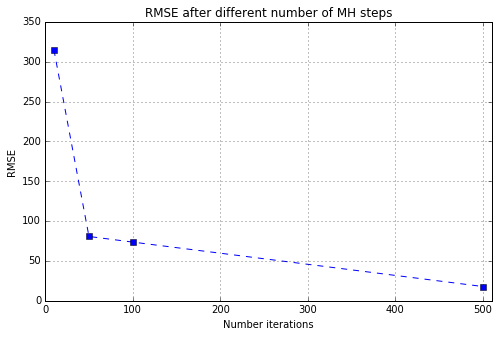

In [27]:
%%venturescript
define number_iterations = [10, 50, 100, 500];
define RMSE_values = [
    RMSE(test_output, get_predictive_mean(gp_posterior_predictive_after_10_iterations)),  
    RMSE(test_output, get_predictive_mean(gp_posterior_predictive_after_50_iterations)),  
    RMSE(test_output, get_predictive_mean(gp_posterior_predictive_after_100_iterations)),  
    RMSE(test_output, get_predictive_mean(gp_posterior_predictive_after_500_iterations))   
];
define plotting_args_accuracy = dict(
    ["xlabel", "Number iterations"],
    ["ylabel", "RMSE"],
    ["title", "RMSE after different number of MH steps"],
    ["width", 8],
    ["height", 5],
    ["linestyle", "--"],
    ["marker", "s"],
    ["color", "blue"],
    ["xlim", [0, 510]]
);
line_plot(number_iterations, RMSE_values, plotting_args_accuracy);

**Figure 2: RMSE vs. time spent on inference.** The plot shows an improvement for
predictive accuracy, measured as root mean square error (RMSE) with increasing number 
of iterations used for inference.


#### GP posterior predictive.

The posterior provides different hypotheses for how the data is generated.
Each hypothesis can also be used to make predictions about future data.
The posterior predictive are the predictions made by choosing a random hypothesis
generated by inference, and using that hypothesis to project forward in time, 
predicting new data.

The RMSE after 500 iterations seems low. Let's inspect the GP posterior predictive for the trace in this state and plot it against the training and test data to get an idea about the model fit.

In [28]:
%%venturescript
define x_input = linspace(0.0001, 13, 100);
define gp_posterior_predictive = mapv(
    (_) -> {run(sample(gp(${x_input})))},
    arange(number_of_curves)
);

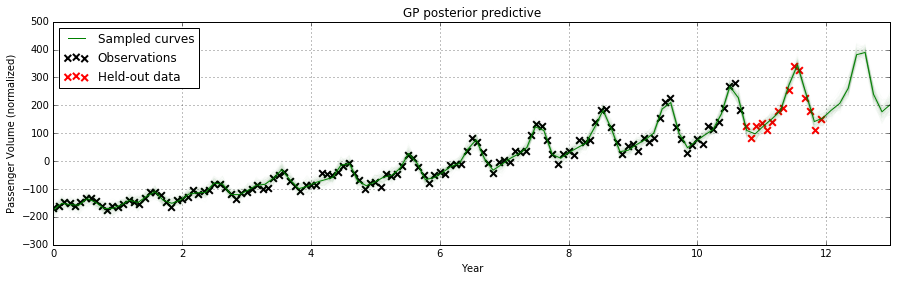

In [29]:
%%venturescript
define plotting_args_curves = dict(
    ["xlabel", "Year"],
    ["ylabel", "Passenger Volume (normalized)"],
    ["title", "GP posterior predictive"],
    ["label", "Sampled curves"],
    ["width", 15],
    ["height", 4],
    ["alpha", 0.01],
    ["color", "green"],
    ["xlim", [0, 13]]
);
scatter_plot(observed_input, observed_output, plotting_args_scatter);
define plotting_args_scatter_test_data = dict(
        ["markersize", 45],
        ["color", "red"],
        ["label", "Held-out data"]
);
scatter_plot(test_input, test_output, plotting_args_scatter_test_data);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_input, 
                lookup(gp_posterior_predictive, i),
                plotting_args_curves

            )
        )
    } 
);
line_plot(x_input, get_predictive_mean(gp_posterior_predictive));
legend("upper left");

**Figure 3: GP posterior predictive.** The figure depicts 100 posterior samples (light
green, the mean of those curves is dark green) drawn from
the GP created with the probabilistic program synthesis model after 500 steps of MH ).
The training data is shown in black. The held-out data used to compute the results shown in
figure 2 are depicted in red. The covariance structure covers the dynamics of this time series; it clearly captures both: a linear trend and a periodic component.


Finally we would like to investigate which symbolic structure encoded the GP model that the posterior predictive curves were sampled from. 

In [30]:
%%venturescript
sample source

['*',
 ['+',
  ['*',
   ['+',
    ['+', ['LIN', 7.294314421523231], ['C', 232.59105289395168]],
    ['C', 129.38618170876882]],
   ['+',
    ['+',
     ['PER', 3.2000328764399257, 8.95732275863816],
     ['LIN', 0.25908463525569436]],
    ['C', 190.58400428691803]]],
  ['+',
   ['+',
    ['WN', 159.2681843197157],
    ['PER', 3.4946055356665973, 0.25368455493225406]],
   ['C', 152.48909982366814]]],
 ['PER', 2.7410668543276904, 2.005940752678708]]

## 7. Compare posterior predictive with Bayesian linear regresssion

In order to compare probabilistic program synthesis to a simple baseline, we constrain the GP to model Bayesian linear regression by setting the structure to be `C * LIN + WN`.

#### Fixing a specific structure
In VentureScript, the function `set_value_at_scope_block` modifies the trace,
allowing a user to constrain the trace using the tagging syntax. 

It does so by taking a scope and a block (corresponding to tags defined in the model)
and a value.
`set_value_scope_block` then sets the random choice at this scope and block to a
specific value.

This is needed, because `observe` does not allow constraining deterministic values.
Thus writing `observe source = ['PER', 1., 2.]`
would attempt to constrain the outer function of `source`, which happens to be the
list-function.

As a first step, we set the branching structure:

In [31]:
%%venturescript
set_value_at_scope_block(quote(structure), pair("branch", 1), True);
set_value_at_scope_block(quote(structure), pair("branch", 2), True);
set_value_at_scope_block(quote(structure), pair("branch", 3), False);
set_value_at_scope_block(quote(structure), pair("branch", 4), False);
set_value_at_scope_block(quote(structure), pair("branch", 5), False);

Next, we set the operators correctly.

In [32]:
%%venturescript
set_value_at_scope_block(quote(structure), pair("operator", 1), "+");
set_value_at_scope_block(quote(structure), pair("operator", 2), "*");

Finally, we choose the three types of base kernels at the right positions:

In [33]:
%%venturescript
set_value_at_scope_block(quote(structure), 3, 0);
set_value_at_scope_block(quote(structure), 4, 1);
set_value_at_scope_block(quote(structure), 5, 2);

In [34]:
%%venturescript
mh(minimal_subproblem(/?hypers), 100);

In [35]:
%%venturescript
define lin_reg_posterior_predictive = mapv(
    (_) -> {run(sample(gp(${x_input})))},
    arange(number_of_curves)
);

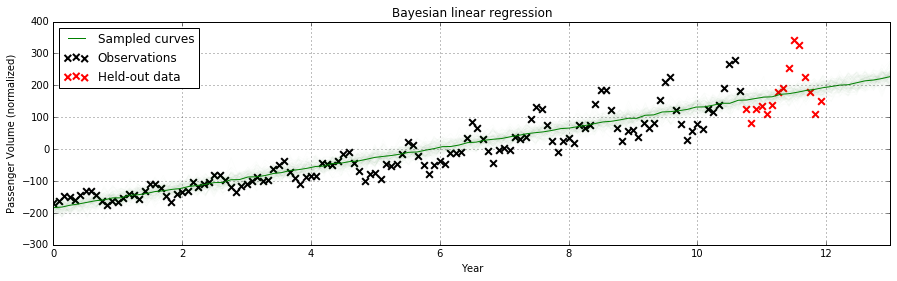

In [36]:
%%venturescript
scatter_plot(observed_input, observed_output, plotting_args_scatter);
define plotting_args_scatter_test_data = dict(
        ["markersize", 45],
        ["color", "red"],
        ["label", "Held-out data"]
);
scatter_plot(test_input, test_output, plotting_args_scatter_test_data);
for_each(
    arange(number_of_curves),
    (i) -> {
        action(
            line_plot(
                x_input, 
                lookup(lin_reg_posterior_predictive, i),
                plotting_args_curves

            )
        )
    } 
);
define plotting_title = dict(
        ["title", "Bayesian linear regression"]
);
line_plot(x_input, get_predictive_mean(lin_reg_posterior_predictive), plotting_title);
legend("upper left");

**Figure 4: Posterior predictive of Bayesian linear regression.**
The figure depicts 100 posterior samples drawn from a Bayesian linear regression model.
This model was created by constraining the structure of the GP. This model only captures 
the linear component of the data.

## 8. References
[1]
David Duvenaud, James Lloyd, Roger Grosse, Joshua Tenenbaum, and Zoubin Ghahramani. 
Structure discovery in nonparametric regression through compositional 
kernel search. In Proceedings of the International Conference on Machine Learning (ICML), pages 1166–1174,2013.

[2]
James Lloyd, David Duvenaud, Roger Grosse, Joshua Tenenbaum, and Zoubin Ghahramani.
Automatic construction and natural-language description of nonparametric regression models.
In AAAI Conference on Artificial Intelligence, pages 1242–1250, 2014.

[3] 
Carl Rasmussen and Hannes Nickisch. Gaussian processes for machine learning (gpml) toolbox.
Journal of Machine Learning Research, 11(Nov):3011–3015, 2010.